# Preprocess IBTRACK data


```{image}../2-Scenarios-used-by-the-National-Weather-Service-to-predict-hurricane-tracks.jpg
:alt: Hurricane Spaghetti Model Tracks (https://smartcorp.com/blog/what-silicon-valley-bank-can-learn-from-supply-chain-planning/attachment/2-scenarios-used-by-the-national-weather-service-to-predict-hurricane-tracks/)
:width: 300px


---

## Overview
The first step of any machine learning algorithm is to first load in, filter, and then process the necessary data. Here, we will load in the hurricane track data from IBTRACKS and then filter the tracks by requirements that we will set.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to NUMPY](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to PANDAS](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to XARRAY](https://foundations.projectpythia.org/core/xarray/) | Necessary | |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
import xarray as xr 
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import glob
from global_land_mask import globe
import cartopy.feature as cfeature
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import patheffects

## Read in IBTRACKS data

First, read in the data as a csv file

In [5]:
ib_data = '../test_folder/ibtracs.NA.list.v04r00.csv'

## Method to preprocess the track data
The following method will set custom ranges for the time period and spatial domain of analysis.

In [6]:
def process_ibrack(ib_loc, periods=[2000,2005]):

    #Read in the IBTRACKS data
    read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
    
    #Get the units for each column in read_ib_data
    units = read_ib_data.iloc[0,:]

    #Get data or the remainder of read_ib_data
    ib_original_dft = read_ib_data.iloc[1:,:]

    #Set a custom date and time range based on user choosing
    ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
    year_mask = (ib_original_dft['datetime'] > f'{periods[0]}-1-1') & (ib_original_dft['datetime'] <= f'{periods[1]}-11-30')
    ib_new_period = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']

    #Only use cyclones over the North Atlantic basin
    #This can be changed to include more cyclones outside of the Northeast Atlantic
    def only_na_basin(df):
        lon_wise = df.sort_values(by='datetime')
        if lon_wise['LON'].iloc[0] > -55:
            return df
        else:
            return None

    #Get the number of time steps in each cyclone, or event
    only_neatlantic = ib_new_period.groupby('SID').apply(only_na_basin).reset_index(drop=True)
    counts = only_neatlantic.groupby('SID').count().iloc[:,0]
    
    #Get cyclones that last at least 12 time steps
    counts_12 = counts[counts > 12].index
    persist_storms = ib_new_period[ib_new_period['SID'].isin(counts_12)]
    persist_storms['month']= persist_storms['datetime'].dt.month
    
    # mask out land points
    def mask_lands(df):
        ordered_df = df.sort_values(by='datetime')
        lat = ordered_df['LAT']
        lon = ordered_df['LON']
        ocean_mask = pd.Series(globe.is_ocean(lat=lat,lon=lon))
        idx_false = ocean_mask.idxmin()
        if idx_false == 0:
            return df
        else:
            land_mask = ocean_mask.iloc[:idx_false]
            final_masked = ordered_df.iloc[:idx_false,:]
            return final_masked
   
    # filter extratropical parts of the storm tracks
    def filter_ET(df):
        ordered_df = df.sort_values(by='datetime')
        lat_filter = ordered_df['LAT'] <= 35
        filter_df = ordered_df[lat_filter]
        return filter_df
    
    exclude_et = persist_storms.groupby('SID').apply(filter_ET).reset_index(drop=True)

    final_dft = exclude_et.groupby('SID').apply(mask_lands).reset_index(drop=True)

    return final_dft

## Process IBTRACKS data using the above methods

In [7]:
ib_data_processed = process_ibrack(ib_data,periods=[2000,2005])
ib_data_processed['LAT'] = ib_data_processed['LAT'].astype(float)
ib_data_processed['LON'] = ib_data_processed['LON'].astype(float)
ib_data_processed['USA_WIND'] = ib_data_processed['USA_WIND'].astype(float)
ib_data_processed['datetime'] = pd.to_datetime(ib_data_processed['datetime'],format='%Y-%m-%d %H:%M:%S')
ib_data_processed['SID'] = ib_data_processed['SID'].astype(str)

/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_81830/278484491.py:4: DtypeWarning: Columns (1,2,8,9,14,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  read_ib_data = pd.read_csv(ib_loc,keep_default_na=False)
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_81830/278484491.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ib_original_dft['datetime'] = pd.to_datetime(ib_original_dft['ISO_TIME'],format='%Y-%m-%d %H:%M:%S')
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_81830/278484491.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ib_new_period = ib_original_dft[year_mask][ib_original_dft['BASIN'] == 'NA']
/var/folders/bt/kswp8

## Organize the edited IBTRACKS file

:::{hint}
Up until now, we have primarily been grouping the IBTRACKS data using SID. Starting in this block, we will begin grouping the IBTRACKS data by id. This is done since SID may erroneously connect some cyclone tracks at adjacent time steps, while id appears to keep them separate.
:::

In [8]:
ib_data_processed['id'] = ib_data_processed['SID'].astype('category')
ib_data_processed['id'] = ib_data_processed['id'].cat.codes
req_cols = ['datetime','LAT','LON','USA_WIND','id']

# groupby datetime 6h 
ib_data_processed['datetime'] = ib_data_processed['datetime'].dt.floor('6h')

ib_data_processed_6h = ib_data_processed[req_cols].groupby('datetime').mean().reset_index()

# copy the SID based on the id

ib_data_processed_6h['SID'] = ib_data_processed.groupby('datetime')['SID'].first().values

## See the organized and edited IBTRACKS file 

In [9]:
ib_data_processed_6h

,datetime,LAT,LON,USA_WIND,id,SID
0,2000-06-23 00:00:00,9.515070,-20.08375,26.0,0.0,2000175N09340
1,2000-06-23 06:00:00,9.667420,-21.37375,30.0,0.0,2000175N09340
2,2000-06-23 12:00:00,9.990000,-23.07115,30.0,0.0,2000175N09340
3,2000-06-23 18:00:00,10.193600,-24.93630,30.0,0.0,2000175N09340
4,2000-06-24 00:00:00,10.046155,-26.60755,30.0,0.0,2000175N09340
...,...,...,...,...,...,...
1158,2005-11-28 06:00:00,30.004350,-24.02575,60.0,46.0,2005324N27312
1159,2005-11-28 12:00:00,30.210150,-20.76440,60.0,46.0,2005324N27312
1160,2005-11-28 18:00:00,30.180200,-17.31015,58.5,46.0,2005324N27312
1161,2005-11-29 00:00:00,30.251750,-13.69805,53.5,46.0,2005324N27312


## Plot the track data we have edited and organized


:::{note}
You may notice some instances in which the cyclone track hits the top of the boundary, and then appears to erroneously move horizontally over a long distance. Not to worry! This occurs since we discount all cyclones that move north of our boundary. Thus, the plot below will connect the two cyclone positions before and after it leaves the domain. The data is however correct.
:::

(<Figure size 2000x1000 with 1 Axes>, <GeoAxes: >)

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


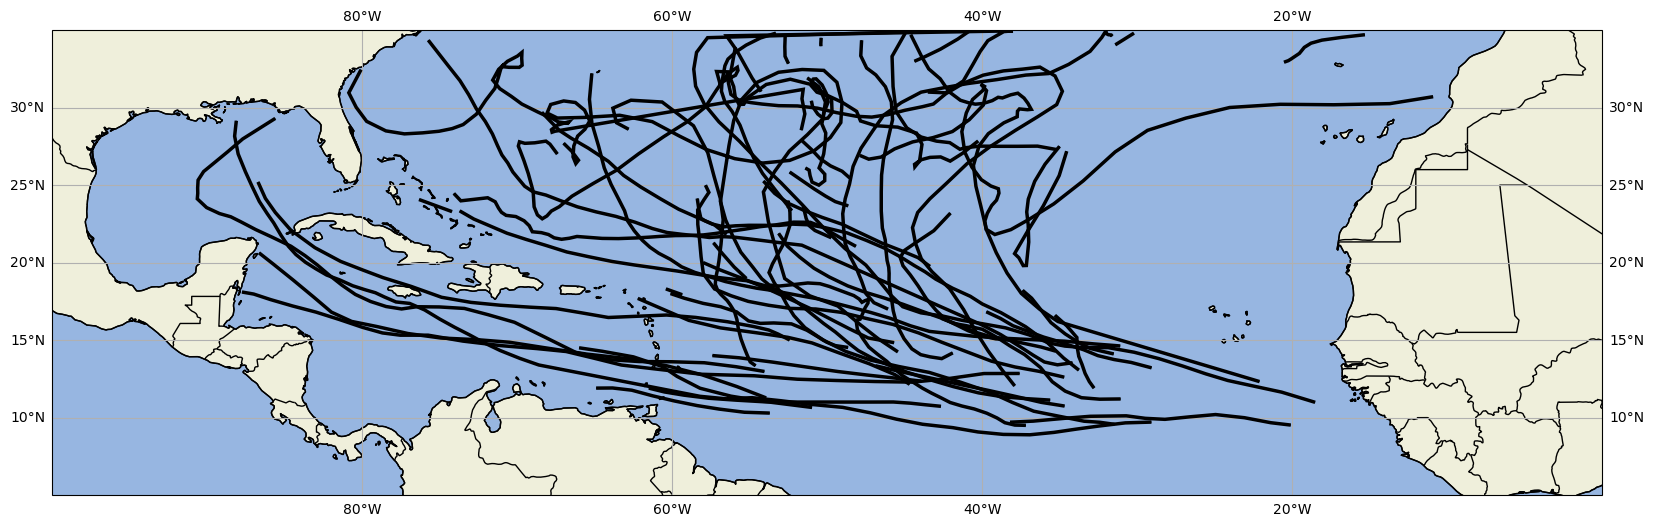

In [10]:
def plot_tracks(filtered_ib):
    filtered_ib['datetime'] = pd.to_datetime(filtered_ib['datetime'])

    events = filtered_ib.groupby('id')
    
    fig,ax = plt.subplots(figsize=(20,10),subplot_kw={"projection": ccrs.PlateCarree()})
    
    ax.add_feature(cfeature.COASTLINE)

    ax.add_feature(cfeature.BORDERS)


    ax.coastlines()
    
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
  
    for event_num , event in events:
        lon = event['LON'].values
        lat = event['LAT'].values

        vertices = [(lo, la) for lo, la in zip(lon, lat)]
        codes = [Path.MOVETO]
        [codes.append(Path.LINETO) for index in range(0, len(event) - 1)]

        path = Path(vertices, codes)
        
        patch = patches.PathPatch(path, lw = 1, fc = 'none', path_effects = [patheffects.withStroke(linewidth=2.5, foreground="black")], zorder = 5)

        ax.add_patch(patch)
        
        ax.set_xlim(-100, 0)
        ax.set_ylim(5, 35)
    return fig,ax

plot_tracks(ib_data_processed_6h)

In [14]:
ib_data_processed_6h.to_csv('../test_folder/ib_data_processed_6h.csv')

---

## Summary
Here, we appropriately edited the cyclone track data over our space and time domain of interest. We have also created an output file that will be useful for eventual creation and training of our machine learning model.

### What's next?
Next we will edit the ERA5 data. In particular, we will take our variables of interest that will be used to train the AI model and organize them for ingestion into the machine learning model. 

## Resources and references
Image link: https://smartcorp.com/blog/what-silicon-valley-bank-can-learn-from-supply-chain-planning/attachment/2-scenarios-used-by-the-national-weather-service-to-predict-hurricane-tracks/